In [1]:
import numpy as np
import pandas as pd
import scipy
from matplotlib import pyplot as plt
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))
from src.load_covid19 import load_clean_covid19
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.metrics import Recall

In [2]:
current_dir = os.getcwd()
file_path = os.path.join(os.path.dirname(current_dir), "data", "raw", "covid19-dataset", "Covid Data.csv")
df = pd.read_csv(file_path)

In [3]:
def get_scores(y_test, y_pred):
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    return acc, f1, prec, rec

In [4]:
#Wir fügen zuerst ein neues Attribut hinzu, das angibt, ob die Person gestorben ist oder nicht. 
#Die Verschlüsselung erfolgt konsistent mit den anderen Attributen (2 für "nein", 1 für "ja").
#Das Todesdatum wird als Attribut verworfen. 

df['DIED'] = [2 if i=='9999-99-99' else 1 for i in df.DATE_DIED]
df=df.drop(columns='DATE_DIED')

In [5]:
#Eine Analyse der Missing Values zeigt, dass diese vor allem in den Spalten "PREGNANT", "ICU" und "INTUBED" vorkommen.
#Das Attribut "PREGNANT" wird bei allen männlichen Patienten auf 2 gesetzt.
#Das Attribut "PATIENT_TYPE" gibt an, ob die Person hospitalisiert war oder nicht. Bei allen Patienten ohne
#Krankenhausaufenthalt kann das Attribut "ICU" auf 2 gesetzt werden, da keiner dieser Patienten folglich auf
#einer Intensivstation behandelt wurde. 
#Dieselbe Vorgehensweise wenden wir auf das Attribut "INTUBED" an. Dazu gehen wir von der Grundannahme aus, dass
#ein Anschluss an ein Beatmungsgerät im Rahmen eines Klinikaufenthaltes erfolgt. Etwaige Fälle von Heimintubation 
#vernachlässigen wir dabei. 

df.loc[df.SEX==2,'PREGNANT']=2
df.loc[df.PATIENT_TYPE==1,'ICU']=2
df.loc[df.PATIENT_TYPE==1,'INTUBED']=2

In [6]:
#Für die anderen fehlenden Werte können keine sinnvollen Aussagen getroffen werden. Da sie nur einen sehr kleinen
#Anteil des gesamten Datensatzes ausmachen (2.76%), verwerfen wir sie. 

for col in df.columns.drop('AGE'):
    for i in [97,98, 99]:
        df[col]=df[col].replace(i , np.nan)

df=df.dropna()

In [7]:
df.columns

Index(['USMER', 'MEDICAL_UNIT', 'SEX', 'PATIENT_TYPE', 'INTUBED', 'PNEUMONIA',
       'AGE', 'PREGNANT', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR',
       'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY',
       'RENAL_CHRONIC', 'TOBACCO', 'CLASIFFICATION_FINAL', 'ICU', 'DIED'],
      dtype='object')

In [8]:
#Wir normieren das Attribut "AGE" auf das Intervall [0,1] und bilden die "2" bei den binären Attributen auf die "0" ab
df['AGE'] = (df['AGE'] - df['AGE'].min()) / (df['AGE'].max() - df['AGE'].min())

for col in df.columns.drop(['AGE','CLASIFFICATION_FINAL', 'MEDICAL_UNIT', 'PATIENT_TYPE', 'USMER']):
    re_map_dict = {2:0}
    df[col]=df[col].replace(re_map_dict)

In [9]:
#Als Zielvariable wählen wir "DIED" aus
target='DIED'

In [10]:
#Wir verwerfen die beiden Attribute 'MEDICAL_UNIT' und 'USMER'

discarded_features = ['MEDICAL_UNIT', 'USMER','PATIENT_TYPE','INTUBED','ICU','PNEUMONIA']
df = df.drop(discarded_features, axis=1)

#Wir testen die Attribute auf Korrelation mit der Zielvariablen testen und verwerfen alle Attribute,
#die unter einem gewissen Schwellwert liegen. (->andere Feature Selection Methoden ausprobieren)

threshold=0.04
selected_features=df.corr()[target][abs(df.corr()[target])>threshold].index
not_selected_features=df.corr()[target][abs(df.corr()[target])<threshold]
print(not_selected_features)
df=df[selected_features]

PREGNANT   -0.021001
ASTHMA     -0.017690
TOBACCO     0.005625
Name: DIED, dtype: float64


In [11]:
#Wir teilen den Datensatz in Trainings- und Testdatensatz auf. 

test_size=0.2
train, test = train_test_split(df, test_size=test_size, shuffle=True)

train_y = train[target]
train_x = train.drop(target,axis=1)

In [12]:
#Da die Werte der Zielvariablen unbalanciert sind, wenden wir ein SMOTE-Oversampling an,
#um ein balanciertes Trainingsset zu erreichen. (-> auch Undersampling probieren)

sm = SMOTE()
train_x, train_y = sm.fit_resample(train_x, train_y)

test_y = test[target]
test_x = test.drop(target,axis=1)

Klassifikator: GaussianNB

Accuracy: 0.8483185736561829
F1: 0.33524595448391464
Precision: 0.2441543806930228
Recall: 0.5347593582887701

Klassifikator: MultinomialNB

Accuracy: 0.8001461257073367
F1: 0.31432849380057537
Precision: 0.20827109575298183
Recall: 0.6404771698889345

Klassifikator: BernoulliNB

Accuracy: 0.7794629635078015
F1: 0.28659803626096475
Precision: 0.1864333326454382
Recall: 0.619361031125737

Klassifikator: DecisionTreeClassifier

Accuracy: 0.815420675316524
F1: 0.35513602412115397
Precision: 0.23671949938336453
Recall: 0.7106129164952695

Klassifikator: LogisticRegression

Accuracy: 0.7974491747330018
F1: 0.3666027754350993
Precision: 0.23610973947737462
Recall: 0.8195529960235842



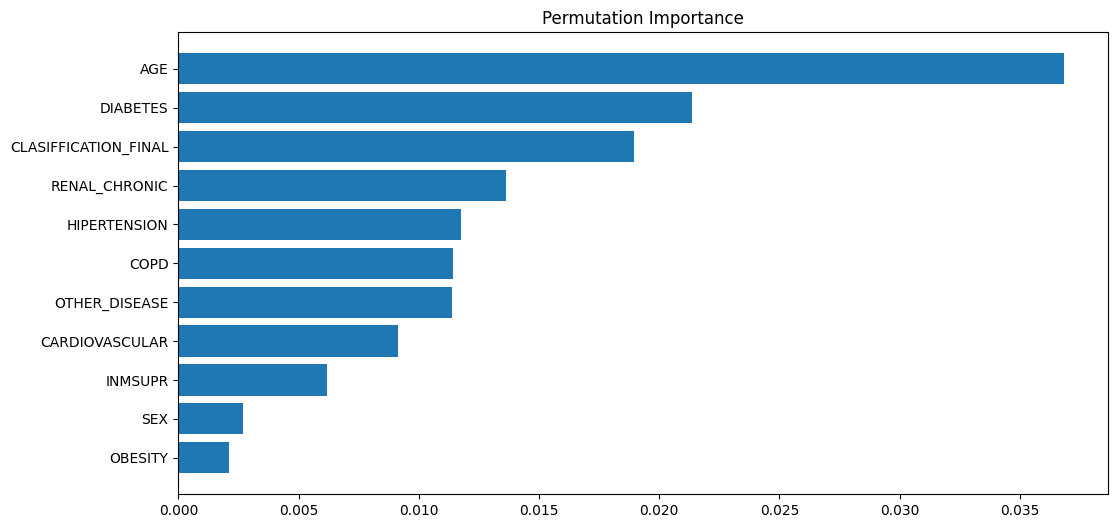

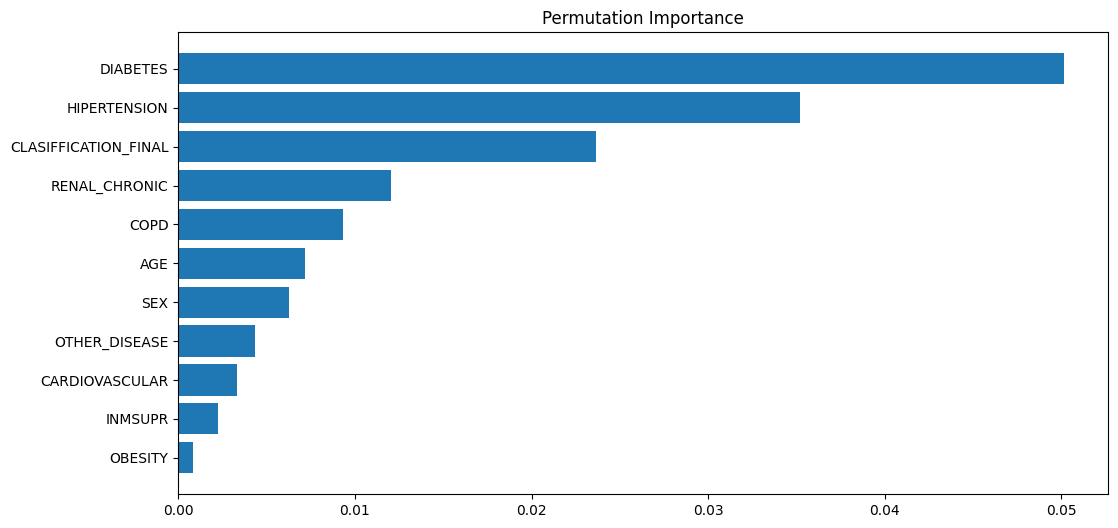

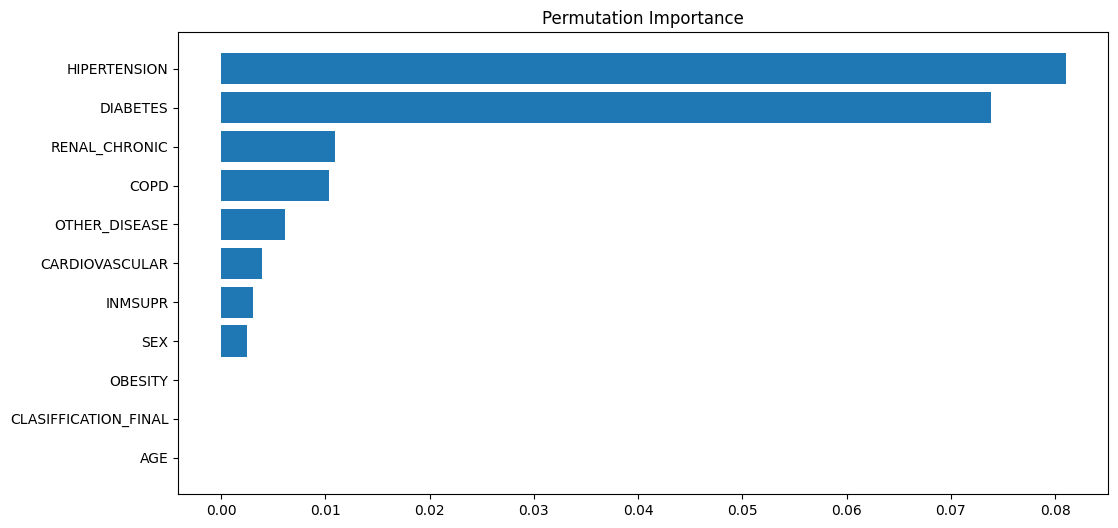

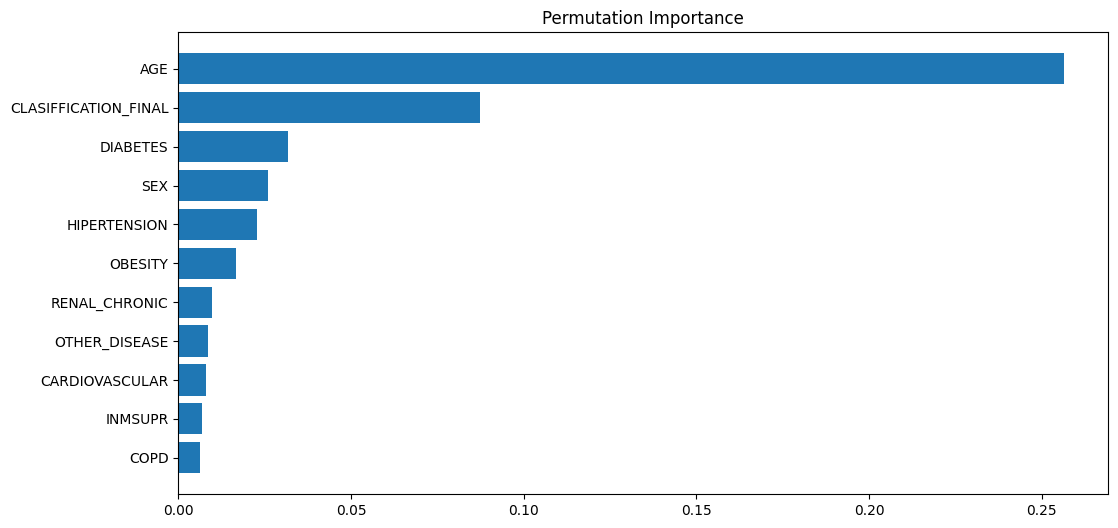

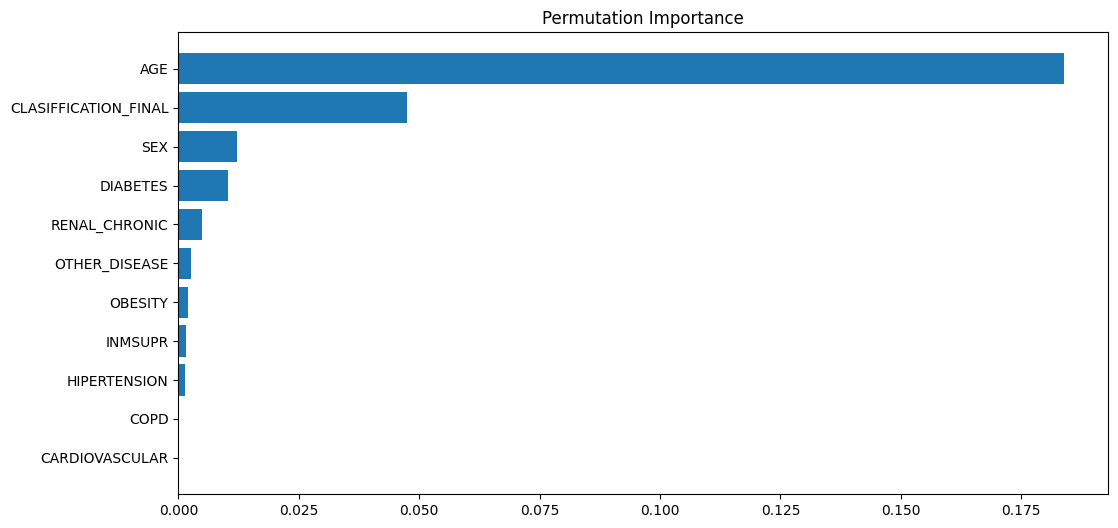

In [13]:
#Wir wenden drei "herkömmliche" Methoden zum maschinellen Lernen eines Klassifikators an:
#Naive Bayes, Entscheidungsbäume bzw. Random Forests und die Logistische Regression. 
#(->verschiedene Parameter für die Klassifier ausprobieren und optimieren)
#(->SVM und KNN eventuell auch ausprobieren)


for clf in [GaussianNB(),MultinomialNB(),BernoulliNB(),DecisionTreeClassifier(),LogisticRegression(max_iter=500)]:
    #if clf==LogisticRegression():
        #train_x = StandardScaler().fit(train_x)
        #test_x  = StandardScaler().fit(test_x)
    clf.fit(train_x,train_y)
    
    perm_importance = permutation_importance(clf, train_x, train_y, n_repeats=10)
    sorted_idx = perm_importance.importances_mean.argsort()
    fig = plt.figure(figsize=(12, 6))
    plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), np.array(test_x.columns)[sorted_idx])
    plt.title('Permutation Importance')
    
    y_pred=clf.predict(test_x)
    acc, f1, prec, rec = get_scores(test_y, y_pred)
    print(f"Klassifikator: "+type(clf).__name__+"\n")
    print(f'Accuracy: {acc}')
    print(f'F1: {f1}')
    print(f'Precision: {prec}')
    print(f'Recall: {rec}'+"\n")


C:\Users\peter\covid-19-risiko-erkennung\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Best Validation Loss: 0.4041
Best Validation Accuracy: 0.8508
6373/6373 ━━━━━━━━━━━━━━━━━━━━ 2s 381us/step
Accuracy: 0.8279100101013073
F1: 0.38238037414427256
Precision: 0.25784402145535673
Recall: 0.7396010620191981



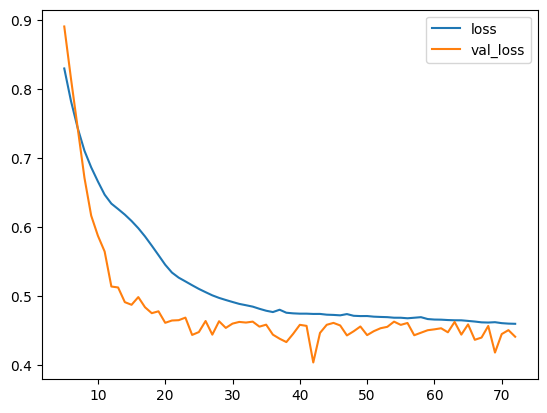

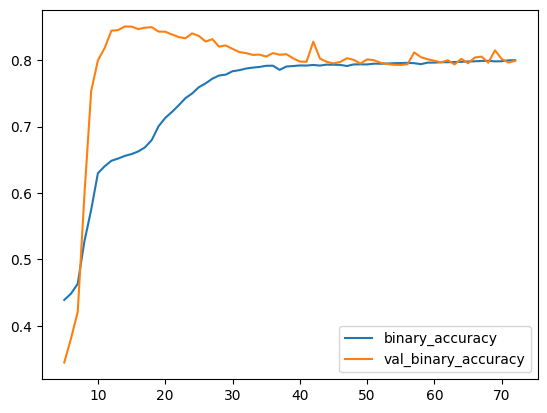

In [39]:
#Wir wenden einen Deep-Learning-Ansatz auf den Datensatz an.

model = keras.Sequential([
        layers.Dense(8, activation='relu', input_shape=[train_x.shape[1]]),
        layers.Dense(8, activation='relu'),
        layers.Dense(1)])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
model.optimizer.learning_rate.assign(0.0001)
    
early_stopping = keras.callbacks.EarlyStopping(patience=30, min_delta=0.001, restore_best_weights=True)

history = model.fit(train_x, train_y, validation_data=(test_x, test_y), batch_size=2048, epochs=1000, 
                    callbacks=[early_stopping], verbose=0)

history_df = pd.DataFrame(history.history)
history_df.loc[5:, ['loss', 'val_loss']].plot()
history_df.loc[5:, ['binary_accuracy', 'val_binary_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" + "\nBest Validation Accuracy: {:0.4f}").format(history_df['val_loss'].min(),
                  history_df['val_binary_accuracy'].max()))
    
y_pred=model.predict(test_x)
acc, f1, prec, rec = get_scores(test_y, np.round(abs(y_pred)))
print(f'Accuracy: {acc}')
print(f'F1: {f1}')
print(f'Precision: {prec}')
print(f'Recall: {rec}'+"\n")
